# CNN-based Regressor model
The goal is to train and evaluate a model that, given a droplets' segmentation mask, predicts the following statistics:
- left contact angle
- right contact angle
- volume
- ellipse xc (x coordinate of the center of the ellipse)
- ellipse yc (y coordinate of the center of the ellipse)
- ellipse a (half the length of the major axis of the ellipse)
- ellipse b (half the length of the minor axis of the ellipse)
- ellipse theta (rotation angle of the ellipse (in radians), counter-clockwise from the x-axis to the ellipse’s major axis)
- bbox x (x coordinate of the left bottom vertex of the bounding box)
- bbox y (y coordinate of the left bottom vertex of the bounding box)
- bbox w (width of the bounding box)
- bbox h (height of the bounding box)

## Defining the dataset

In [ ]:
import os
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import numpy as np
import torchvision.transforms as transforms

MASK_DIR = "../3. Segmentation and Detection Models/droplet_masks"
REGRESSION_INFO_PATH = "../5. Robust Estimation and Evaluation Methods/analysis/droplet_analysis.csv"

transform = transforms.Compose([
    transforms.Resize((180, 240)), # the original images from the video are 720x540, and 180x240 preserves the aspect ratio (4:3)
    transforms.ToTensor()
])

class DropletRegressionDataset(Dataset):
    def __init__(self, mask_dir, csv_path, transform=None):
        """
        mask_dir: path to folder containing binary masks (as .png files)
        csv_path: path to CSV file containing the frame code and the 13 regression values
        transform: optional torchvision or custom transform
        """
        self.mask_dir = mask_dir
        self.df = pd.read_csv(csv_path)
        self.df.drop(self.df[self.df.Valid == 'False'].index, inplace=True) # drops not valid rows
        self.df.drop(columns=['Volume_Loss', 'Valid'], inplace=True)
        self.df.dropna(inplace=True)
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx] # read row idx from the dataframe
        frame_code = int(row["Frame"])
        frame_code_str = f"{frame_code:03d}"
        mask_path = os.path.join(self.mask_dir, f"frame_{frame_code_str}_mask.png")

        # Load the binary mask image (L = grayscale)
        mask = Image.open(mask_path).convert("L")

        # Apply transformations (e.g., resize, ToTensor, normalize)
        if self.transform:
            mask = self.transform(mask)
        else:
            # Default: convert to tensor and normalize to [0, 1]
            mask = torch.tensor(np.array(mask), dtype=torch.float32).unsqueeze(0) / 255.0

        # Load 12 regression targets
        targets = torch.tensor(row[1:].values.astype(np.float32))  # exclude filename

        return mask, targets


In [11]:
dataset = DropletRegressionDataset(mask_dir=MASK_DIR, csv_path=REGRESSION_INFO_PATH, transform=transform)

# Create DataLoader for testing
dataloader = DataLoader(dataset, batch_size=4, shuffle=True)

# Fetch a single batch
masks, targets = next(iter(dataloader))

# Display some info
print("Masks shape:", masks.shape)       # Expect [B, 1, H, W]
print("Targets shape:", targets.shape)   # Expect [B, 12]
print("First sample targets:\n", targets[0])

Masks shape: torch.Size([4, 1, 180, 240])
Targets shape: torch.Size([4, 12])
First sample targets:
 tensor([ 1.2067e+02,  1.2053e+02,  6.8095e+04,  3.9439e+02,  2.6502e+02,
         1.6344e+02,  1.5157e+02, -1.9544e+00,  2.3000e+02,  1.1300e+02,
         3.2900e+02,  2.4800e+02])


Split the dataset in (80%) train and (20%) test

In [12]:
from torch.utils.data import random_split, DataLoader

# Define dataset lengths
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size

# Split the dataset
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

# Define data loaders
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

## Defining the model

In [13]:
import torch.nn as nn

class DropletCNNRegressor(nn.Module):
    def __init__(self):
        super().__init__()
        self.features = nn.Sequential(
            # input size (1, 180, 240)
            nn.Conv2d(1, 16, kernel_size=3, padding=1), nn.ReLU(), # (16, 180, 240)
            nn.Conv2d(16, 32, kernel_size=3, padding=1), nn.ReLU(), # (32, 180, 240)
            nn.MaxPool2d(2),  # Output: (32, 90, 120), halves width and length

            nn.Conv2d(32, 64, kernel_size=3, padding=1), nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, padding=1), nn.ReLU(),
            nn.MaxPool2d(2),  # Output: (64, 45, 60)

            nn.Conv2d(64, 128, kernel_size=3, padding=1), nn.ReLU(),
            nn.MaxPool2d(2)   # Output: (128, 22, 30)
        )

        dummy_input = torch.zeros(1, 1, 180, 240)
        out = self.features(dummy_input)
        self.flattened_size = out.view(1, -1).size(1)

        self.regressor = nn.Sequential(
            nn.Flatten(),
            nn.Linear(self.flattened_size, 256), nn.ReLU(),
            nn.Linear(256, 64), nn.ReLU(),
            nn.Linear(64, 12)  # Output: 12 regression values
        )

    def forward(self, x):
        x = self.features(x)
        return self.regressor(x)

## Training

In [14]:
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = DropletCNNRegressor().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

num_epochs = 40
patience = 3

# Early stopping and tracking
best_val_loss = float('inf')
patience_counter = 0
train_losses = []
val_losses = []
val_r2_scores = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    train_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Train]", ncols=100)

    for images, labels in train_bar:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        train_bar.set_postfix(loss=loss.item())

    avg_train_loss = running_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    # Validation
    model.eval()
    val_loss = 0.0
    all_preds, all_labels = [], []
    val_bar = tqdm(test_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Val]", leave=True, ncols=100)

    with torch.no_grad():
        for images, labels in val_bar:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            all_preds.append(outputs.cpu().numpy())
            all_labels.append(labels.cpu().numpy())
            val_bar.set_postfix(val_loss=loss.item())

    avg_val_loss = val_loss / len(test_loader)
    val_losses.append(avg_val_loss)

    # R^2 for this validation epoch
    all_preds_np = np.vstack(all_preds)
    all_labels_np = np.vstack(all_labels)
    val_r2 = r2_score(all_labels_np, all_preds_np)
    val_r2_scores.append(val_r2)

    print(f"Epoch [{epoch+1}/{num_epochs}] - Train Loss: {avg_train_loss:.4f} - Val Loss: {avg_val_loss:.4f} - Val R²: {val_r2:.4f}")

    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        patience_counter = 0
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print("Early stopping: Validation loss did not improve.")
            break


Epoch 1/40 [Val]: 100%|███████████████████████████| 63/63 [05:59<00:00,  5.70s/it, val_loss=8.42e+4]


Epoch [1/40] - Train Loss: 112920113.0067 - Val Loss: 1500473.3630 - Val R²: -9.8227


Epoch 2/40 [Val]: 100%|███████████████████████████| 63/63 [01:12<00:00,  1.14s/it, val_loss=1.31e+5]


Epoch [2/40] - Train Loss: 1274990.4970 - Val Loss: 863819.4950 - Val R²: -24.2337


Epoch 3/40 [Val]: 100%|███████████████████████████| 63/63 [01:19<00:00,  1.26s/it, val_loss=7.18e+4]


Epoch [3/40] - Train Loss: 587080.5065 - Val Loss: 268300.1228 - Val R²: -142.9682


Epoch 4/40 [Val]: 100%|███████████████████████████| 63/63 [01:23<00:00,  1.33s/it, val_loss=4.54e+3]


Epoch [4/40] - Train Loss: 128118.8726 - Val Loss: 43887.5447 - Val R²: -208.2123


Epoch 5/40 [Val]: 100%|███████████████████████████| 63/63 [01:11<00:00,  1.13s/it, val_loss=1.06e+3]


Epoch [5/40] - Train Loss: 32104.9516 - Val Loss: 23611.3869 - Val R²: -127.4146


Epoch 6/40 [Val]: 100%|███████████████████████████| 63/63 [01:22<00:00,  1.30s/it, val_loss=1.93e+3]


Epoch [6/40] - Train Loss: 21892.3649 - Val Loss: 19450.2459 - Val R²: -54.9842


Epoch 7/40 [Val]: 100%|███████████████████████████████| 63/63 [01:24<00:00,  1.35s/it, val_loss=725]


Epoch [7/40] - Train Loss: 17965.7543 - Val Loss: 15080.1489 - Val R²: -26.9994


Epoch 8/40 [Val]: 100%|███████████████████████████| 63/63 [01:26<00:00,  1.37s/it, val_loss=1.07e+3]


Epoch [8/40] - Train Loss: 14905.5397 - Val Loss: 12862.1552 - Val R²: -18.8542


Epoch 9/40 [Val]: 100%|███████████████████████████| 63/63 [01:12<00:00,  1.15s/it, val_loss=1.71e+3]


Epoch [9/40] - Train Loss: 11650.5160 - Val Loss: 9909.6791 - Val R²: -15.2368


Epoch 10/40 [Val]: 100%|██████████████████████████| 63/63 [01:26<00:00,  1.37s/it, val_loss=2.49e+3]


Epoch [10/40] - Train Loss: 8896.3867 - Val Loss: 7918.8489 - Val R²: -14.8157


Epoch 11/40 [Val]: 100%|██████████████████████████████| 63/63 [01:22<00:00,  1.30s/it, val_loss=123]


Epoch [11/40] - Train Loss: 6839.5418 - Val Loss: 5206.7237 - Val R²: -11.9267


Epoch 12/40 [Val]: 100%|██████████████████████████████| 63/63 [01:40<00:00,  1.59s/it, val_loss=255]


Epoch [12/40] - Train Loss: 4668.7708 - Val Loss: 3409.9931 - Val R²: -10.0431


Epoch 13/40 [Val]: 100%|██████████████████████████| 63/63 [01:25<00:00,  1.36s/it, val_loss=1.28e+3]


Epoch [13/40] - Train Loss: 3646.6708 - Val Loss: 2921.6734 - Val R²: -7.7108


Epoch 14/40 [Val]: 100%|██████████████████████████| 63/63 [01:29<00:00,  1.43s/it, val_loss=2.17e+3]


Epoch [14/40] - Train Loss: 3019.4426 - Val Loss: 2915.0402 - Val R²: -5.9905


Epoch 15/40 [Val]: 100%|██████████████████████████████| 63/63 [01:38<00:00,  1.56s/it, val_loss=104]


Epoch [15/40] - Train Loss: 2549.3476 - Val Loss: 1556.8764 - Val R²: -4.0799


Epoch 16/40 [Val]: 100%|█████████████████████████████| 63/63 [01:18<00:00,  1.24s/it, val_loss=26.2]


Epoch [16/40] - Train Loss: 2082.4214 - Val Loss: 1400.5898 - Val R²: -2.9098


Epoch 17/40 [Val]: 100%|██████████████████████████| 63/63 [01:22<00:00,  1.30s/it, val_loss=8.22e+3]


Epoch [17/40] - Train Loss: 1710.9652 - Val Loss: 7379.2045 - Val R²: -2.1031


Epoch 18/40 [Val]: 100%|█████████████████████████████| 63/63 [01:39<00:00,  1.58s/it, val_loss=36.7]


Epoch [18/40] - Train Loss: 1798.8408 - Val Loss: 1115.1407 - Val R²: -0.8278


Epoch 19/40 [Val]: 100%|██████████████████████████| 63/63 [01:27<00:00,  1.38s/it, val_loss=5.68e+3]


Epoch [19/40] - Train Loss: 1580.8239 - Val Loss: 5433.8996 - Val R²: -0.6810


Epoch 20/40 [Val]: 100%|██████████████████████████████| 63/63 [01:27<00:00,  1.39s/it, val_loss=253]


Epoch [20/40] - Train Loss: 1602.0198 - Val Loss: 1326.0695 - Val R²: 0.0512


Epoch 21/40 [Val]: 100%|██████████████████████████████| 63/63 [01:40<00:00,  1.60s/it, val_loss=742]

Epoch [21/40] - Train Loss: 1576.6546 - Val Loss: 1315.3843 - Val R²: 0.1872
Early stopping: Validation loss did not improve.


In [ ]:
MODEL_SAVE_PATH = "droplet_cnn_regressor.pth"
torch.save(model.state_dict(), MODEL_SAVE_PATH)
print(f"Model saved to {MODEL_SAVE_PATH}")

Model saved to /content/drive/MyDrive/Pi2/droplet_cnn_regressor.pth


## Evaluating the model

In [16]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import random

model.eval()
all_preds = []
all_targets = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        outputs = model(images).cpu().numpy()
        labels = labels.cpu().numpy()

        all_preds.append(outputs)
        all_targets.append(labels)

all_preds = np.vstack(all_preds)
all_targets = np.vstack(all_targets)

mae = mean_absolute_error(all_targets, all_preds)
mse = mean_squared_error(all_targets, all_preds)
r2 = r2_score(all_targets, all_preds)

print(f"\nFinal Evaluation:")
print(f"  MAE  = {mae:.4f}")
print(f"  MSE  = {mse:.4f}")
print(f"  R²   = {r2:.4f}")

print("\nSample Predictions (3 random examples):")
indices = random.sample(range(len(all_targets)), 3)
for i in indices:
    print(f"\nExample {i+1}:")
    print(f"  Ground truth : {np.round(all_targets[i], 2)}")
    print(f"  Prediction   : {np.round(all_preds[i], 2)}")



Final Evaluation:
  MAE  = 12.1089
  MSE  = 1323.4630
  R²   = 0.1872

Sample Predictions (3 random examples):

Example 988:
  Ground truth : [ 1.1984e+02  1.1979e+02  6.4824e+04  3.9406e+02  2.7031e+02  1.6050e+02
  1.4897e+02 -6.5000e-01  2.3200e+02  1.2100e+02  3.2400e+02  2.4000e+02]
  Prediction   : [1.194300e+02 1.192600e+02 6.494104e+04 3.967300e+02 2.633100e+02
 1.589100e+02 1.482800e+02 1.900000e+00 2.311700e+02 1.191700e+02
 3.236200e+02 2.409300e+02]

Example 760:
  Ground truth : [ 1.2178e+02  1.2274e+02  7.9083e+04  3.9699e+02  2.5133e+02  1.7467e+02
  1.6044e+02 -9.8000e-01  2.2100e+02  9.1000e+01  3.5100e+02  2.7000e+02]
  Prediction   : [1.142900e+02 1.219200e+02 7.926912e+04 4.000800e+02 2.545500e+02
 1.698400e+02 1.561900e+02 3.110000e+00 2.234600e+02 8.731000e+01
 3.479200e+02 2.669600e+02]

Example 154:
  Ground truth : [1.2248e+02 1.2279e+02 5.3599e+04 4.2881e+02 2.7168e+02 1.4264e+02
 1.3371e+02 4.3400e+00 2.8500e+02 1.3800e+02 2.8700e+02 2.2300e+02]
  Prediction

## Plotting

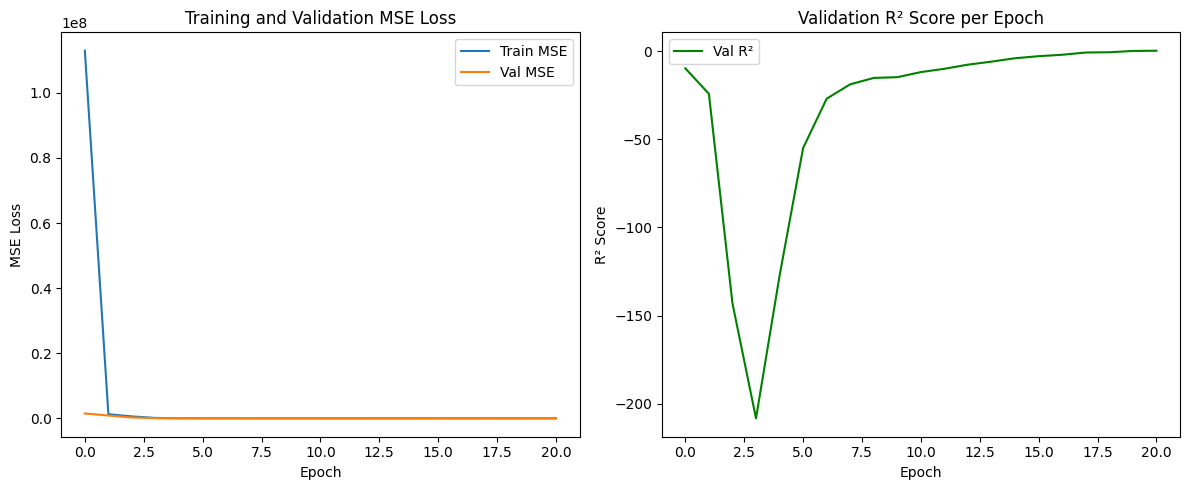

In [17]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train MSE')
plt.plot(val_losses, label='Val MSE')
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.title("Training and Validation MSE Loss")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(val_r2_scores, label='Val R²', color='green')
plt.xlabel("Epoch")
plt.ylabel("R² Score")
plt.title("Validation R² Score per Epoch")
plt.legend()

plt.tight_layout()
plt.show()